# Week 11 - Markov chain Monte Carlo methods

Hello again. Welcome to week 11! In this week, you will learn about Markov chain Monte Carlo.

The usual imports...

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Part 0.1 - Generate artificial data: Ancestral sampling

In this notebook, we shall consider a simple Bayesian linear regression corresponding to the following generative process:

1. Draw $\boldsymbol\beta \sim \mathcal{N}(\textbf{0}, \lambda \textbf{I})$
2. For each input vector $x_n$
    3. Draw target variable $y_n \sim \mathcal{N}(\beta_0 + \beta_1 x_n, \sigma^2)$
    
where $\boldsymbol\beta$ is a 2-dimensional vector with values $\boldsymbol\beta = (\beta_0, \beta_1)^T$, so that the values of $\beta_0$ and $\beta_1$ correspond, respectively, to the intercept and slope of the regression line.

If we include a column of $1$s in the inputs, such that they consist of vectors $\textbf{x}_n = (1, x_n)^T$, then we can write the likelihood as

\begin{align}
y_n \sim \mathcal{N}(\boldsymbol\beta^T \textbf{x}_n, \sigma^2)
\end{align}

For the sake of simplicity, we shall assume the values of $\lambda$ and $\sigma^2$ to be given.

In [3]:
lambda_ = 1
sigma = 0.1
sigma2 = sigma**2

We also need to generate some input vectors $\textbf{x}_n$. We shall use simple Gaussian distribution to sample $N$ points:

In [4]:
N = 20
X = np.concatenate([np.ones(N)[:,np.newaxis], np.random.normal(0.3, 1, size=N)[:,np.newaxis]], axis=1)

We can now use ancestral sampling to sample from our Bayesian linear regression model:

In [5]:
def ancestral_sampling(X, lambda_, sigma):
    # sample coefficients (beta): intercept + slope
    beta = np.random.multivariate_normal(np.zeros(2), lambda_*np.eye(2))
    print("beta:", beta)

    # sample observations (y's)
    y = np.zeros(N)
    print("sampled observations:")
    for n in range(N):
        y[n] = np.random.normal(np.dot(beta, X[n]), sigma)
        print("x[%d]=%.3f\t->     y[%d]: %.3f" % (n, X[n,1], n, y[n]))
        
    return beta, y

In [6]:
beta, y = ancestral_sampling(X, lambda_, sigma)

beta: [ 1.46564877 -0.2257763 ]
sampled observations:
x[0]=0.797	->     y[0]: 1.293
x[1]=0.162	->     y[1]: 1.287
x[2]=0.948	->     y[2]: 1.197
x[3]=1.823	->     y[3]: 1.065
x[4]=0.066	->     y[4]: 1.336
x[5]=0.066	->     y[5]: 1.488
x[6]=1.879	->     y[6]: 0.981
x[7]=1.067	->     y[7]: 1.195
x[8]=-0.169	->     y[8]: 1.444
x[9]=0.843	->     y[9]: 1.461
x[10]=-0.163	->     y[10]: 1.501
x[11]=-0.166	->     y[11]: 1.397
x[12]=0.542	->     y[12]: 1.426
x[13]=-1.613	->     y[13]: 1.708
x[14]=-1.425	->     y[14]: 1.808
x[15]=-0.262	->     y[15]: 1.329
x[16]=-0.713	->     y[16]: 1.494
x[17]=0.614	->     y[17]: 1.347
x[18]=-0.608	->     y[18]: 1.677
x[19]=-1.112	->     y[19]: 1.734


We can visualize our $N$ sampled observations pairs $\{(x_n, y_n)\}_{n=1}^N$

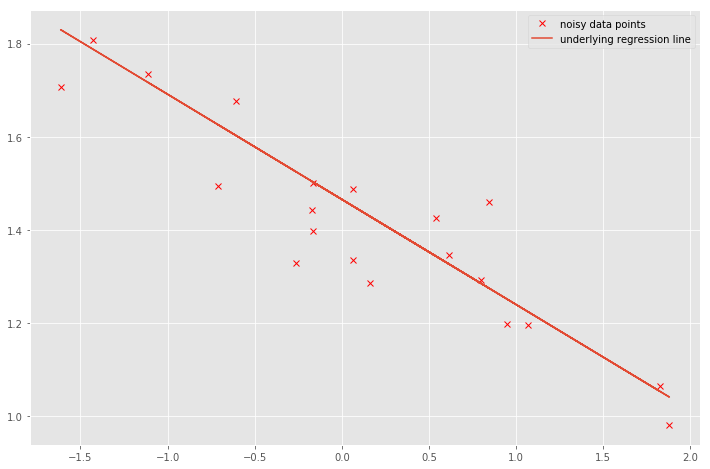

In [7]:
plt.plot(X[:,1], y, "rx")
plt.plot(X[:,1], np.dot(X, beta))
plt.legend(["noisy data points", "underlying regression line"])
plt.show()

## Part 0.2 - Exact inference

The joint probability of our model is given by:

\begin{align}
p(\textbf{y},\boldsymbol\beta|\textbf{X},\lambda,\sigma) = p(\boldsymbol\beta|\textbf{0},\lambda\textbf{I}) \prod_{n=1}^N p(y_n|\boldsymbol\beta^T \textbf{x}_n, \sigma^2)
\end{align}

Since both our prior $p(\boldsymbol\beta|\lambda)$ and likelihood $p(y_n|\textbf{x}_n,\boldsymbol\beta,\sigma)$ are both Gaussian, and the Gaussian is the conjugate prior for mean of a Gaussian (with fixed variance), we directly apply Bayes' theorem to compute the posterior distribution over $\boldsymbol\beta$:

\begin{align}
\underbrace{p(\boldsymbol\beta|\textbf{y},\textbf{X},\lambda,\sigma)}_{\mbox{posterior}} &\propto \underbrace{p(\boldsymbol\beta|\textbf{0},\lambda\textbf{I})}_{\mbox{prior}} \, \underbrace{\prod_{n=1}^N p(y_n|\boldsymbol\beta^T \textbf{x}_n, \sigma^2)}_{\mbox{likelihood}}\\
&= \mathcal{N}(\boldsymbol\beta|\textbf{0},\lambda\textbf{I}) \prod_{n=1}^N \mathcal{N}(y_n|\boldsymbol\beta^T \textbf{x}_n, \sigma^2)\\
&= \mathcal{N}(\boldsymbol\mu,\boldsymbol\Sigma)
\end{align}

where 

\begin{align}
\boldsymbol\mu &= \boldsymbol\Sigma \, (\sigma^{-2} \textbf{X}^T \textbf{y})\\
\boldsymbol\Sigma &= (\lambda^{-1} + \sigma^{-2} \textbf{X}^T \textbf{X})^{-1}
\end{align}

In [8]:
Sigma = np.linalg.inv(1/lambda_ + np.dot(X.T,X) / sigma2)
print("Sigma:", Sigma)

Sigma: [[ 5.09269109e-04 -7.37123628e-05]
 [-7.37123628e-05  5.70808033e-04]]


In [9]:
mu = np.dot(Sigma, (1/sigma2) * np.dot(X.T,y))
print("mu:", mu)

mu: [ 1.43418609 -0.20556931]


In [10]:
beta_exact = mu
print("beta (exact inference):", beta_exact)
print("true beta:             ", beta)

beta (exact inference): [ 1.43418609 -0.20556931]
true beta:              [ 1.46564877 -0.2257763 ]


Quite close, right? Notice that we only observed a small sample of data points $(\textbf{x}_n, y_n)$. The more points we observe, the closer this posterior should get to the true value of $\boldsymbol\beta$.

## Part 1 - Rejection sampling

Lets now implement a rejection sampling algorithm for approximating the posterior distribution on $\boldsymbol\beta$.

Let $p(x)$ be the true distribution which we wish to approximate. 

In rejection sampling, we sample from a tractable distribution $x \sim q(x)$ that satisfies $k \, q(x) \geq p(x)$. We then sample a height from $u \sim \mbox{Uniform}(0,k \, q(x))$. If $u \geq p(x)$, we reject the sample. Otherwise, $x$ is retained.

In order to implement rejection sample, we first need to implement a function that computes the log joint probability of our Bayesian linear regression model:

In [11]:
from scipy.stats import norm, multivariate_normal

# computes log joint probability of the model (y, X, lambda and sigma are assume to be fixed/given)
def log_joint_prob(beta):
    # log probability of the prior
    lp = multivariate_normal.logpdf(beta, np.zeros(2), lambda_*np.eye(2))
    
    # log likelihood
    for n in range(N):
        lp += norm.logpdf(y[n], np.dot(beta, X[n]), sigma)
        
    return lp

# a few tests checks
print(log_joint_prob([0,0]))
print(log_joint_prob([1,1]))
print(log_joint_prob(beta))

-2001.9969832058214
-1332.2483646111896
15.937836566338662


We can now implement rejection sampling:

In [12]:
def rejection_sampling(S, k):
    samples = []
    rejects = []
    for s in range(S):
        # TODO: Implement rejection samplig
        # NOTE: Save accepted samples in the "samples" array; 
        # save rejected samples in the array "rejects" for analysis
        candidate = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
        q_x       = multivariate_normal.pdf(candidate, np.zeros(2), np.eye(2))
        height    = np.random.uniform(low=0, high=k*q_x)
        if height < np.exp(log_joint_prob(candidate)):
            samples.append(candidate)
        else:
            rejects.append(candidate)
            
        if s % 1000 == 0:
            print("{} samples drawn...".format(s))
        
    return np.array(samples), np.array(rejects)

And run it...

In [13]:
#%%time 
# measure execution time

S = 20000 # number of samples
k = 477169210 # multiplication factor in k*q(x)

# run rejection sampling
samples, rejects = rejection_sampling(S, k)
print("num. accepted samples:", len(samples))

# compute the expected value of beta as the mean of all the samples
beta_rs = np.mean(samples, axis=0)
print("beta (rejection samp.):", beta_rs)

print("beta (exact inference):", beta_exact)
print("true beta:             ", beta)

0 samples drawn...
1000 samples drawn...
2000 samples drawn...
3000 samples drawn...
4000 samples drawn...
5000 samples drawn...
6000 samples drawn...
7000 samples drawn...
8000 samples drawn...
9000 samples drawn...
10000 samples drawn...
11000 samples drawn...
12000 samples drawn...
13000 samples drawn...
14000 samples drawn...
15000 samples drawn...
16000 samples drawn...
17000 samples drawn...
18000 samples drawn...
19000 samples drawn...
num. accepted samples: 2
beta (rejection samp.): [ 1.45560229 -0.21903383]
beta (exact inference): [ 1.43418609 -0.20556931]
true beta:              [ 1.46564877 -0.2257763 ]


It works, but look at how many samples we kept (i.e. not rejected) from the total number of samples $S$ that were drawn from the proposal distribution. This seem wasteful, right? We are throwing away all these other samples... And this effect is much worse when we go to even higher dimensions! In the next section, we will see how importance sampling tries to address this issue.

But for now, lets look at the regression line corresponding to the approximate expected value of $\boldsymbol\beta$ according to the samples from rejection sampling:

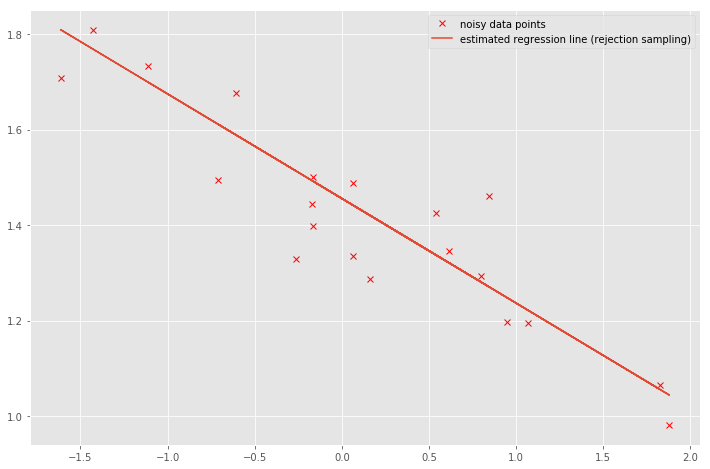

In [14]:
plt.plot(X[:,1], y, "rx")
plt.plot(X[:,1], np.dot(X, beta_rs))
plt.legend(["noisy data points", "estimated regression line (rejection sampling)"])
plt.show()

Since this is a relatively simple problem with just 2 univariate variables ($\beta_0$ and $\beta_1$) to be infered, we can actually visualize the true posterior distribution for pre-defined grid of points.

Recall that the posterior is proportional to the joint probability distribution:
\begin{align}
\underbrace{p(\boldsymbol\beta|\textbf{y},\textbf{X},\lambda,\sigma)}_{\mbox{posterior}} &\propto \underbrace{p(\boldsymbol\beta|\textbf{0},\lambda\textbf{I})}_{\mbox{prior}} \, \underbrace{\prod_{n=1}^N p(y_n|\boldsymbol\beta^T \textbf{x}_n, \sigma^2)}_{\mbox{likelihood}} = \underbrace{p(\textbf{y},\boldsymbol\beta|\textbf{X},\lambda,\sigma)}_{\mbox{joint}}
\end{align}

In [15]:
def plot_true_posterior():
    x = np.arange(-0.5, 3.5, 0.1)
    y = np.arange(-2.0, 2.0, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i,j] = log_joint_prob([x[j], y[i]])
    
    CS = plt.contour(X, Y, Z, colors='blue')
    plt.clabel(CS, inline=1, fontsize=10)

Lets now visualize the accepted samples and (part of) the reject samples on top of the true posterior distribution:

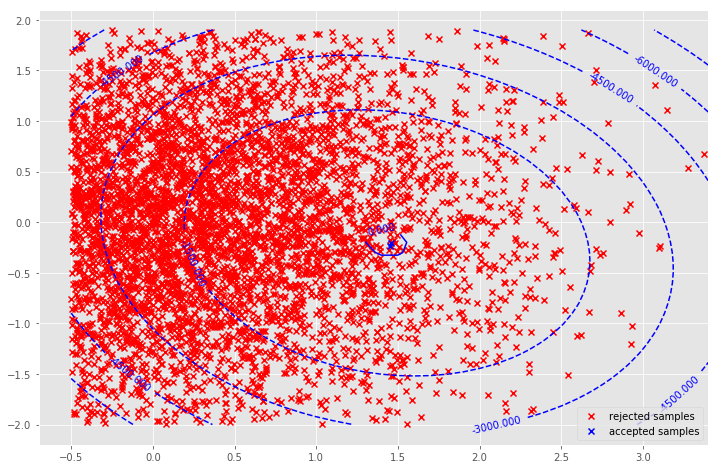

In [16]:
rejects_filtered = rejects[(rejects[:,0] > -0.5) & (rejects[:,0] < 3.4) & 
                           (rejects[:,1] > -2.0) & (rejects[:,1] < 1.9),:]
plt.scatter(rejects_filtered[:5000,0], rejects_filtered[:5000,1], marker='x', color='r')
plt.scatter(samples[:,0], samples[:,1], marker='x', color='b')
plot_true_posterior()
plt.legend(["rejected samples","accepted samples"])
plt.show()

Look at how many "good" samples that were close to the mode of the exact posterior and we still rejected them...

## Part 2 - Importance sampling

Lets now implement an importance sampling algorithm for approximating the posterior distribution on $\boldsymbol\beta$.

In importance sampling, instead of rejecting samples, we assign each sample $x^{(s)}$ a weight $w^{(s)}$ according to the ratio:

\begin{align}
r^{(s)} = \frac{p(x^{(s)})}{q(x^{(s)})}
\end{align}

The sample weights $w$ are then given by:

\begin{align}
w^{(s)} = \frac{r^{(s)}}{\sum_{j=1}^S r^{(j)}}
\end{align}

We can then use the samples and their corresponding weights to compute expectations of the form:

\begin{align}
\int f(x) \, p(x) \, dx \approx \frac{1}{S} \sum_{s=1}^S f(x^{(s)}) \, w^{(s)}
\end{align}

For example, we can compute the expected mean as:

\begin{align}
\int x \, p(x) \, dx \approx \frac{1}{S} \sum_{s=1}^S x^{(s)} \, w^{(s)}
\end{align}

Implementation time! :-)

In [17]:
def importance_sampling(S):
    samples = []
    ratios = []
    for s in range(S):
        # TODO: Implement importance samplig
        # NOTE: Save samples in the "samples" array; 
        # save corresponding ratios in the "ratios" array 
        candidate = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
        q_x       = multivariate_normal.pdf(candidate, np.zeros(2), np.eye(2))
        p_x       = np.exp(log_joint_prob(candidate))
        ratio     = p_x/q_x
        ratios.append(ratio)
        samples.append(candidate)
        if s % 1000 == 0:
            print("{} samples drawn...".format(s))
        
    return np.array(samples), np.array(ratios)

Running it...

In [18]:
#%%time 
# measure execution time

S = 5000 # number of samples

# run importance sampling
samples, ratios = importance_sampling(S)
print("num. usable samples:", len(samples))

# normalize weights so that they sum to 1
weights = ratios / np.sum(ratios)

# estimate beta as a weighted average of the samples
beta_is = np.dot(weights, samples)
print("beta (importance samp.):", beta_is)

print("beta (exact inference): ", beta_exact)
print("true beta:              ", beta)

0 samples drawn...
1000 samples drawn...
2000 samples drawn...
3000 samples drawn...
4000 samples drawn...
num. usable samples: 5000
beta (importance samp.): [ 1.41535005 -0.20507838]
beta (exact inference):  [ 1.43418609 -0.20556931]
true beta:               [ 1.46564877 -0.2257763 ]


Notice how we can do a much better job at approximating the posterior distribution on $\boldsymbol\beta$ with a much smaller number of samples. Also, notice the reduced execution time!

Lets now plot the generated samples and their corresponding weights on top of the true posterior distribution: 

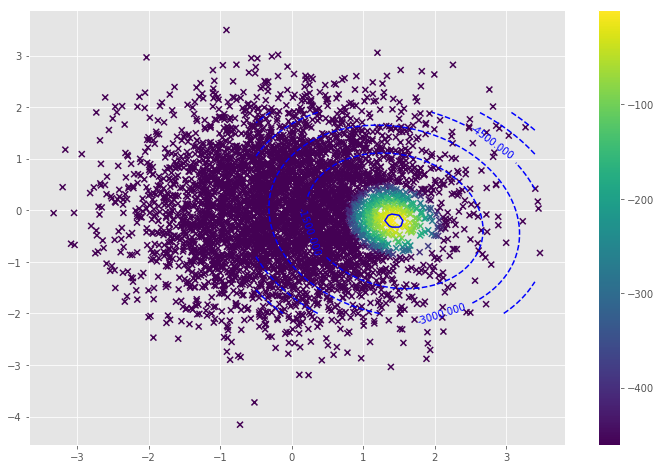

In [19]:
plt.scatter(samples[:,0], samples[:,1], marker='x', c=np.log(weights+1e-200))
plt.colorbar()
plot_true_posterior()
plt.show()

We can even plot the true vs approximate posterior distributions:

In [20]:
def plot_approximate_posterior(mu, cov):
    delta = 0.1
    x = np.arange(-0.5, 3.5, delta)
    y = np.arange(-2.0, 2.0, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i,j] = multivariate_normal.logpdf([x[j], y[i]], mu, cov)
    
    CS = plt.contour(X, Y, Z, colors='red')
    plt.clabel(CS, inline=1, fontsize=10)

In [21]:
# recall that: COV[XX] = VAR[X] = E[XX] - E[X]*E[X]
# also recall that COV[XY] = E[XY] - E[X]*E[Y]
var = np.dot(weights, samples**2) - np.dot(weights, samples)**2
cross = np.dot(weights, samples[:,0]*samples[:,1]) - np.dot(weights, samples[:,0]) * np.dot(weights, samples[:,1])
cov_est = np.array([[var[0], cross], 
                    [cross, var[1]]])
print("estimated covariance matrix:\n", cov_est)

estimated covariance matrix:
 [[ 4.99859713e-05 -7.39556617e-06]
 [-7.39556617e-06  5.26069117e-05]]


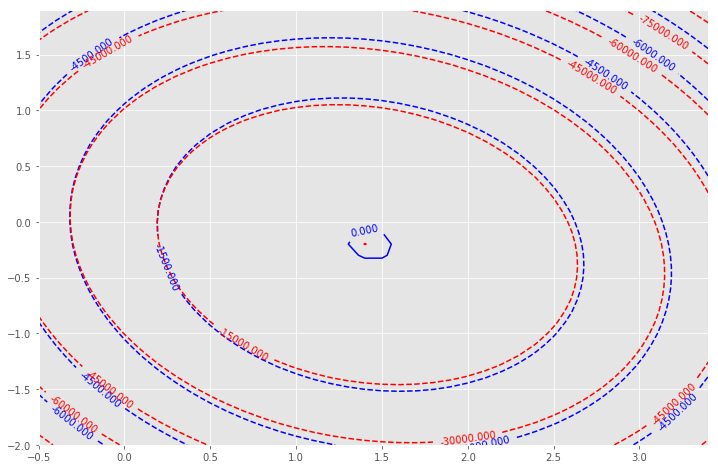

In [22]:
plot_true_posterior()
plot_approximate_posterior(np.dot(weights, samples), cov_est)

The mean shape look good, but the values of the contours are quite off! Also look at how many samples had a weights different than zero:

In [23]:
print("franction of samples with non-zero weight:", len(samples) / S)

franction of samples with non-zero weight: 1.0


So far, all the sampling algorithms that we saw draw samples independently. That means that if get a good sample, we are not able to take advantage of that fact, and in the next iteration we "start everything from scratch" (independence). The Metropolis-Hastings algorithm aims at exploring the latent space more efficiently by taking advantage of knowledge about the previous samples.

## Part 3 - Metropolis-Hastings

Lets now implement a Metropolis-Hastings (MCMC) algorithm for approximating the posterior distribution on $\boldsymbol\beta$.

In Metropolis-Hastings, we start with a initial state $x$. At each iteration, we propose a new state using the proposal distribution $q(x'|x)$, which can be for example a random perturbation of the current state, such that $x' \sim \mathcal{N}(x, \sigma^2)$ (random walk). We then accept the move with probability $\min(1,\frac{p(x')}{p(x)})$. In other words, if the proposed state is "better" (i.e. higher probability), we always accept that move. Otherwise, we can still accept it with probability $\frac{p(x')}{p(x)}$.

Time to implement it! :-)

In [24]:
def metropolis_hastings(S, step_size, burn_in, thin=0):
    assert burn_in < S

    state_0 = np.random.multivariate_normal(np.zeros(2), lambda_*np.eye(2)) # initial state
    lp_state_0 = log_joint_prob(state_0) # log joint probability of current state
    samples = []
    for s in range(S):
        # TODO: Implement Metropolis-Hastings
        # NOTE: Save samples in the "samples" array; 
        samples.append(state_0)
        state_1 = np.random.multivariate_normal(state_0, step_size*np.eye(2))
        lp_state_1 = log_joint_prob(state_1)
        
        acceptance_p = np.minimum(1, np.exp(lp_state_1-lp_state_0))
        if np.random.binomial(1, acceptance_p):
            state_0 = state_1
            lp_state_0 = lp_state_1
            
        if s % 1000 == 0:
            print("{} samples drawn...".format(s))

    # throw away samples from burn-in period
    samples = np.array(samples)
    samples = samples[burn_in:,:]
    
    if thin:
        samples = samples[np.arange(0, len(samples), thin),:]
        
    return np.array(samples)

In [25]:
#%%time 
# measure execution time

S = 2000 # number of samples
step_size = 0.01
burn_in = 1000

# run metropolis-hastings
samples = metropolis_hastings(S, step_size, burn_in, thin=False)

# compute the expected value of beta as the mean of all the samples
beta_mh = np.mean(samples, axis=0)
print("beta (metropolis-hastings): ", beta_mh)

print("beta (exact inference):     ", beta_exact)
print("true beta:                  ", beta)

0 samples drawn...
1000 samples drawn...
beta (metropolis-hastings):  [ 1.43389805 -0.20815189]
beta (exact inference):      [ 1.43418609 -0.20556931]
true beta:                   [ 1.46564877 -0.2257763 ]


Look at how fast that was! Did you get good results? One disadvantage of the MH algorithm is that it requires tunning of its parameters (namely, the step size).

Lets look at the traceplot:

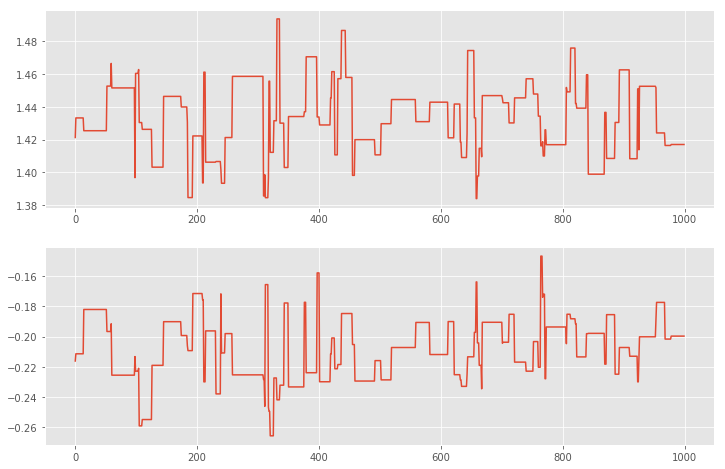

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(samples[:,0]);
ax2.plot(samples[:,1]);

Do they look satisfactory? Has the chain mixed?

Play with the step size parameter and see how it affects the traceplots. Also, see how it affects your estimated values of beta.

As we did for the importance sampling algorithm, we can compate the approximate posterior distribution (MH) with the true one (exact inference):

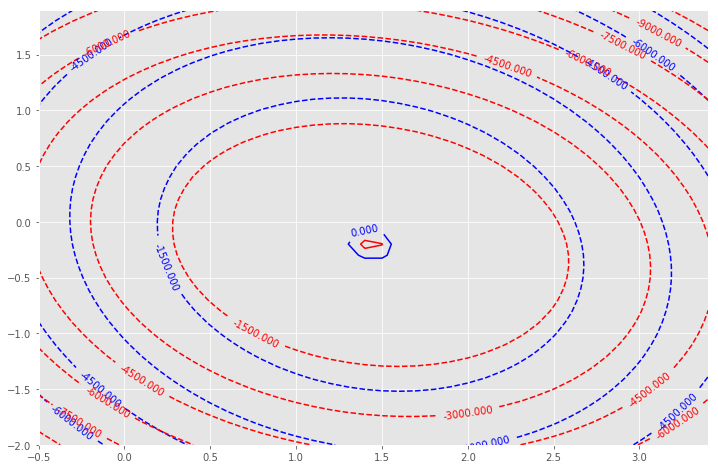

In [27]:
plot_true_posterior()
plot_approximate_posterior(np.mean(samples, axis=0), np.cov(samples.T))

Is the approximation more accurate than with importance sampling? It should be... If not, go back and play with the step size!

## Part 4 - Gibbs sampling

Lastly, lets implement a Gibbs sampling (MCMC) algorithm for approximating the posterior distribution on $\boldsymbol\beta$.

In Gibbs sampling, we sample from each latent variable in turn, conditional on all the other variables. In other words, letting $\textbf{x} = \{x_1,\dots,x_K\}$ denote our latent variables that we wish to infer, in each iteration we sample $x_i \sim p(x_i | \textbf{x}_{j \neq i})$. However, this requires that we can compute $p(x_i | \textbf{x}_{j \neq i})$ analytically! (Actually, approximation methods also exist...)

This is where conjugate priors can make our lifes so much easier! :-)

Lets consider our simple Bayesian linear regression model:

$\beta_0 \sim \mathcal{N}(0, \lambda)$

$\beta_1 \sim \mathcal{N}(0, \lambda)$

$y_n \sim \mathcal{N}(\beta_0 + \beta_1 x_n, \sigma^2)$

Since the priors (Gaussian) are conjugate to the likelihood (also Gaussian), we can easily make use of know results (e.g. check the table in https://en.wikipedia.org/wiki/Conjugate_prior ), to obtain analytical expression for the exact conditionals:

$\beta_0 | \beta_1, \textbf{y}, \textbf{X} \sim \mathcal{N}\bigg(\frac{\sigma^{-2} \sum_{n=1}^N (y_n - \beta_1 x_n)}{\lambda^{-1} + N \sigma^{-2}}, \, \frac{1}{\lambda^{-1} + \sigma^{-2}N}\bigg)$

$\beta_1 | \beta_0, \textbf{y}, \textbf{X} \sim \mathcal{N}\bigg(\frac{\sigma^{-2} \sum_{n=1}^N (y_n - \beta_0) \, x_n}{\lambda^{-1} + \sigma^{-2} \sum_{n=1}^N x_n^2}, \, \frac{1}{\lambda^{-1} + \sigma^{-2} \sum_{n=1}^N x_n^2}\bigg)$

Notice that in Gibbs sampling there are no rejections!

Ok, time to implement it!

In [29]:
def gibbs_sampling(S, burn_in, thin=0):
    assert burn_in < S

    # initialize values of beta
    beta_0 = 0.0
    beta_1 = 0.0
    
    samples = []
    for s in range(S):
        # TODO: Implement Gibbs sampling
        # NOTE: Save samples in the "samples" array
        # Draw from beta 0
        mean_0  = (sigma**-2)*np.sum(y-beta_1*X[:,1])/((lambda_**-1)+N*(sigma**-2))
        sigma_0 = 1/((lambda_**-1)+N*(sigma**-2))
        beta_0  = np.random.normal(loc=mean_0, scale=sigma_0**2)
        
        # Draw from beta 1
        mean_1  = (sigma**-2)*np.sum((y-beta_0)*X[:,1])/((lambda_**-1)+np.sum(X[:,1]**2)*(sigma**-2))
        sigma_1 = 1/((lambda_**-1)+N*(sigma**-2))
        beta_1 = np.random.normal(loc=mean_1, scale=sigma_1**2)
        
        samples.append([beta_0, beta_1])
        
        if s % 1000 == 0:
            print("{} samples drawn...".format(s))

    # throw away samples from burn-in period
    samples = np.array(samples)
    samples = samples[burn_in:,:]
    
    if thin:
        samples = samples[np.arange(0, len(samples), thin),:]
        
    return np.array(samples)

And now, lets run it!

In [30]:
#%%time 
# measure execution time

S = 2000 # number of samples
burn_in = 1000

# run gibbs
samples = gibbs_sampling(S, burn_in, thin=False)

# compute the expected value of beta as the mean of all the samples
beta_gibbs = np.mean(samples, axis=0)
print("beta (gibbs sampling): ", beta_gibbs)

print("beta (exact inference):", beta_exact)
print("true beta:             ", beta)

0 samples drawn...
1000 samples drawn...
beta (gibbs sampling):  [ 1.43397612 -0.2047357 ]
beta (exact inference): [ 1.43418609 -0.20556931]
true beta:              [ 1.46564877 -0.2257763 ]


That was extremely fast, right? Compare that to the execution times of the previous sampling methods. We have been gradually reducing the execution times, but what about the results? They should be very accurate... If not, revise your code!

Sometimes inspecting the traceplots can tell you a lot (great for debugging the behaviour of your chain):

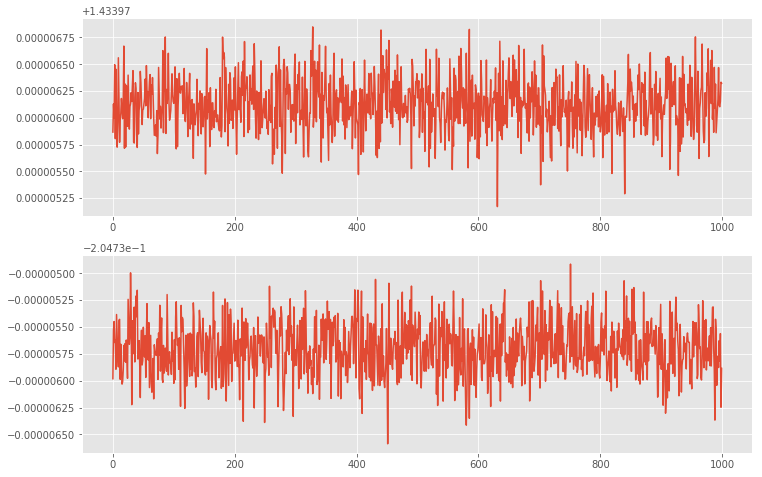

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(samples[:,0]);
ax2.plot(samples[:,1]);

Do they look satisfactory? Has the chain mixed?

Lets now compate the approximate posterior distribution (Gibbs sampling) with the true one (exact inference): 

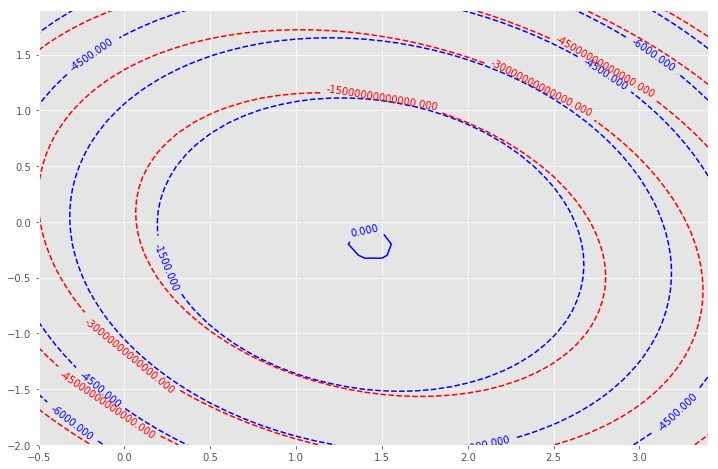

In [32]:
plot_true_posterior()
plot_approximate_posterior(np.mean(samples, axis=0), np.cov(samples.T))

Very accurate, right? Almost matches the true posterior exactly!

Lastly, lets look at a **summary of the results** of the different methods:

In [33]:
print("true beta:                 ", beta)
print("beta (exact inference):    ", beta_exact)
print("beta (rejection sampling): ", beta_rs)
print("beta (importance sampling):", beta_is)
print("beta (metropolis-hastings):", beta_mh)
print("beta (gibbs sampling):     ", beta_gibbs)

true beta:                  [ 1.46564877 -0.2257763 ]
beta (exact inference):     [ 1.43418609 -0.20556931]
beta (rejection sampling):  [ 1.45560229 -0.21903383]
beta (importance sampling): [ 1.41535005 -0.20507838]
beta (metropolis-hastings): [ 1.43389805 -0.20815189]
beta (gibbs sampling):      [ 1.43397612 -0.2047357 ]


We can also compare the esimated regression lines from the different inference methods (exact and approximate!):

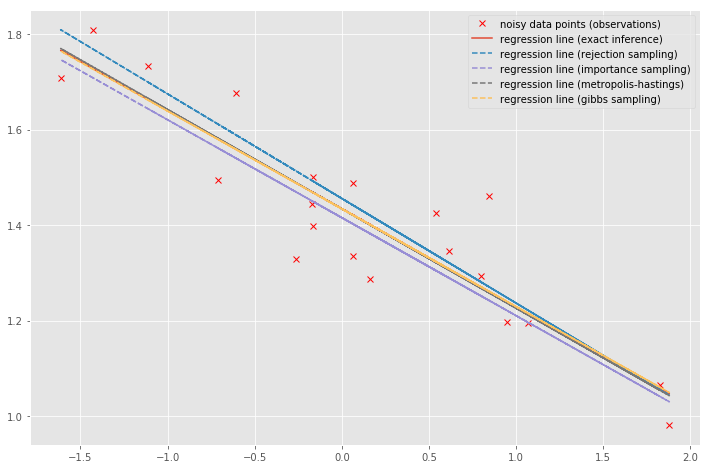

In [34]:
plt.plot(X[:,1], y, "rx")
plt.plot(X[:,1], np.dot(X, beta_exact))
plt.plot(X[:,1], np.dot(X, beta_rs), linestyle='--')
plt.plot(X[:,1], np.dot(X, beta_is), linestyle='--')
plt.plot(X[:,1], np.dot(X, beta_mh), linestyle='--')
plt.plot(X[:,1], np.dot(X, beta_gibbs), linestyle='--')
plt.legend(["noisy data points (observations)", "regression line (exact inference)", 
            "regression line (rejection sampling)", "regression line (importance sampling)", 
            "regression line (metropolis-hastings)", "regression line (gibbs sampling)"])
plt.show()